# COGS 188: AI Algorithms

## The Traveling Salesman Problem

# Introduction
The problem:
In this assignment, we’ll be using a Genetic Algorithm to find a solution to the traveling salesman problem (TSP). The TSP is described as follows:
“Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?”
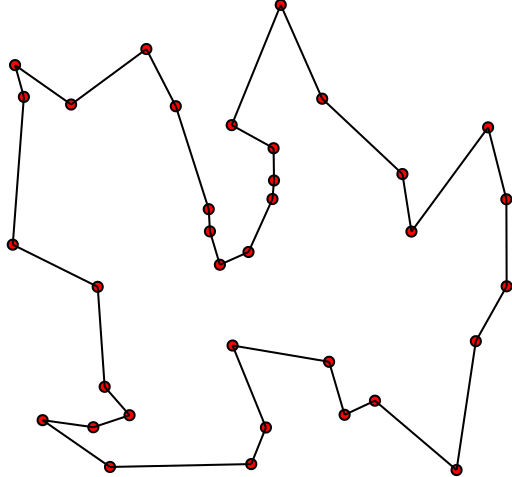
Illustration of a potential solution to the Traveling Salesman Problem.

Given this, there are two important rules to keep in mind:
- Each city needs to be visited exactly one time
- We must return to the starting city, so our total distance needs to be calculated accordingly  
## Approach:  
Let’s start with a few definitions, rephrased in the context of the TSP:
- Gene: a city (represented as (x, y) coordinates)
- Individual (aka “chromosome”): a single route satisfying the conditions above
- Population: a collection of possible routes (i.e., collection of individuals)
- Parents: two routes that are combined to create a new route
- Mating pool: a collection of parents that are used to create our next population (thus creating the next generation of routes)
- Fitness: a function that tells us how good each route is (in our case, how short the distance is)
- Mutation: a way to introduce variation in our population by randomly swapping two cities in a route
- Elitism: a way to carry the best individuals into the next generation    
  
Our GA will proceed in the following steps:
- 1. Create the population
- 2. Determine fitness
- 3. Select the mating pool
- 4. Breed
- 5. Mutate
- 6. Repeat  
Now, let’s see this in action.

## Create necessary classes and functions

Create two classes: City and Fitness  
We first create a City class that will allow us to create and handle our cities. These are simply our (x, y) coordinates. Within the City class, we add a distance calculation (making use of the Pythagorean theorem) in line 6 and a cleaner way to output the cities as coordinates with __repr __.

Create class to handle "cities"

In [123]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

In [124]:
class City:
    def __init__(self, y, x):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

We’ll also create a Fitness class. In our case, we’ll treat the fitness as the inverse of the route distance. We want to minimize route distance, so a larger fitness score is better. Based on Rule #2, we need to start and end at the same place, so this extra calculation is accounted for in line 13  
(if i + 1 < len(self.route))  
of the distance calculation.

In [125]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

## Create our initial population

Route generator.  
We now can make our initial population (aka first generation). To do so, we need a way to create a function that produces routes that satisfy our conditions (Note: we’ll create our list of cities when we actually run the GA at the end of the tutorial). To create an individual, we randomly select the order in which we visit each city:

In [126]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

Create first "population" (list of routes)  
This produces one individual, but we want a full population, so let’s do that in our next function. This is as simple as looping through the createRoute function until we have as many routes as we want for our population.

In [127]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

Note: we only have to use these functions to create the initial population. Subsequent generations will be produced through breeding and mutation.

## Create the genetic algorithm - Determine Fitness

Rank individuals  
Next, the evolutionary fun begins. To simulate our “survival of the fittest”, we can make use of Fitness to rank each individual in the population. Our output will be an ordered list with the route IDs and each associated fitness score.

In [128]:
def rankRoutes(population):
    """
    This function sorts the given population in decreasing order of the fitness score.
    """
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

## Select the mating pool
There are a few options for how to select the parents that will be used to create the next generation. The most common approaches are either fitness proportionate selection (aka “roulette wheel selection”) or tournament selection:
- Fitness proportionate selection (the version implemented below): The fitness of each individual relative to the population is used to assign a probability of selection. Think of this as the fitness-weighted probability of being selected.
- Tournament selection: A set number of individuals are randomly selected from the population and the one with the highest fitness in the group is chosen as the first parent. This is repeated to chose the second parent.  

Another design feature to consider is the use of elitism. With elitism, the best performing individuals from the population will automatically carry over to the next generation, ensuring that the most successful individuals persist.  
For the purpose of clarity, we’ll create the mating pool in two steps. First, we’ll use the output from rankRoutes to determine which routes to select in our selection function. In lines 3–5, we set up the roulette wheel by calculating a relative fitness weight for each individual. In line 9, we compare a randomly drawn number to these weights to select our mating pool. We’ll also want to hold on to our best routes, so we introduce elitism in line 7. Ultimately, the selection function returns a list of route IDs, which we can use to create the mating pool in the matingPool function.

In [129]:
def selection(popRanked, eliteSize):
    """
    This function takes in a population sorted in decreasing order of fitness score, and chooses a mating pool from it.
    It returns a list of indices of the chosen mating pool in the given population.
    """
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Now that we have the IDs of the routes that will make up our mating pool from the selection function, we can create the mating pool. We’re simply extracting the selected individuals from our population.

In [130]:
def matingPool(population, selectionResults):
    """
    This function takes in a population and returns the chosen mating pool which is a subset of the population.
    """
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

## Breed
With our mating pool created, we can create the next generation in a process called crossover (aka “breeding”). If our individuals were strings of 0s and 1s and our two rules didn’t apply (e.g., imagine we were deciding whether or not to include a stock in a portfolio), we could simply pick a crossover point and splice the two strings together to produce an offspring.  
However, the TSP is unique in that we need to include all locations exactly one time. To abide by this rule, we can use a special breeding function called ordered crossover. In ordered crossover, we randomly select a subset of the first parent string (see line 12 in breed function below) and then fill the remainder of the route with the genes from the second parent in the order in which they appear, without duplicating any genes in the selected subset from the first parent (see line 15 in breed function below).
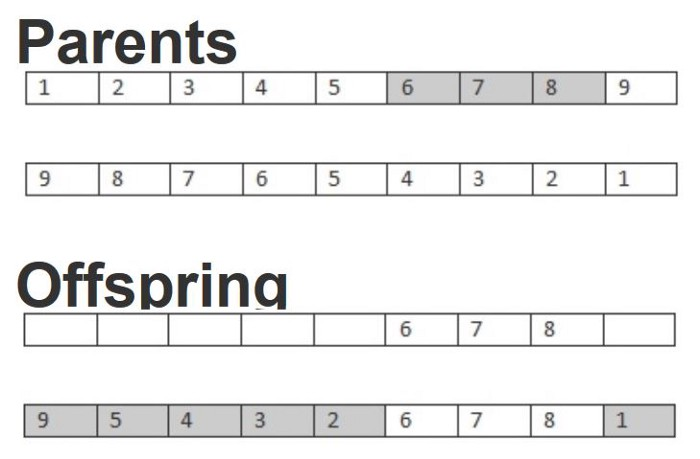

In [147]:
def breed(parent1, parent2):
    """
    This function should breed both parents (routes) and return a child route according to the ordered crossover algorithm  
    mentioned above. Please fill in the code to do so.
    """
    
    child = []
    child_p1 = []
    child_p2 = []
    
    gene_1 = int(random.random() * len(parent1))
    gene_2 = int(random.random() * len(parent1))
    gene_s = min(gene_1, gene_2)
    gene_e = max(gene_1, gene_2)

    for i in range(gene_s, gene_e):
        child_p1.append(parent1[i])
        
    child_p2 = [i for i in parent2 if i not in child_p1]
    child = child_p1 + child_p2
    
    return child

Next, we’ll generalize this to create our offspring population. In line 5, we use elitism to retain the best routes from the current population. Then, in line 8, we use the breed function to fill out the rest of the next generation.

In [148]:
def breedPopulation(matingpool, eliteSize):
    """
    This function should return the offspring population from the current population using the breed function. It should 
    retain the eliteSize best routes from the current population. Then it should use the breed function to mate
    members of the population, to fill out the rest of the next generation. You may decide how to choose mates for individuals.
    """
  
    children = []
    
    pool = random.sample(matingpool, len(matingpool))
    
    span = len(matingpool) - eliteSize

    for i in range(0,eliteSize):
        children.append(matingpool[i])
        
        
        
    for i in range(0, span):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
 

    
    return children

## Mutate
Mutation serves an important function in GA, as it helps to avoid local convergence by introducing novel routes that will allow us to explore other parts of the solution space. Similar to crossover, the TSP has a special consideration when it comes to mutation. Again, if we had a chromosome of 0s and 1s, mutation would simply mean assigning a low probability of a gene changing from 0 to 1, or vice versa (to continue the example from before, a stock that was included in the offspring portfolio is now excluded).  
However, since we need to abide by our rules, we can’t drop cities. Instead, we’ll use swap mutation. This means that, with a specified low probability, two cities will swap places in our route. We’ll do this for one individual in our mutate function:

In [150]:
def mutate(individual, mutationRate):
    """
    This function should take in an individual (route) and return a mutated individual. Assume mutationRate is a probability
    between 0 and 1. Use the swap mutation described above to mutate the individual according to the mutationRate. Iterate 
    through each of the cities and swap it with another city according to the given probability.
    """
    
    for i in range(len(individual)):
        if(random.random() < mutationRate):
            j = int(random.random() * len(individual))
            
            city_1 = individual[i]
            
            city_2 = individual[j]
            
            
            individual[j] = city_1
            individual[i] = city_2
    
    return individual

Next, we can extend the mutate function to run through the new population.  
Create function to run mutation over entire population

In [151]:
def mutatePopulation(population, mutationRate):
    """
    This function should use the above mutate function to mutate each member of the population. Simply iterate over the 
    population and mutate each individual using the mutationRate.
    """
    mutatedPop = []
    for i in range(0, len(population)):
        
        mutated_i = mutate(population[i], mutationRate)
        
        mutatedPop.append(mutated_i)
   
    
    return mutatedPop

## Repeat
We’re almost there. Let’s pull these pieces together to create a function that produces a new generation. First, we rank the routes in the current generation using rankRoutes. We then determine our potential parents by running the selection function, which allows us to create the mating pool using the matingPool function. Finally, we then create our new generation using the breedPopulation function and then applying mutation using the mutatePopulation function.

In [153]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    """
    This function takes in the current generation, eliteSize and mutationRate and should return the next generation.
    Please use all the above defined functions to do so, some hints are in the above paragraph.
    """
    rank_pop = rankRoutes(currentGen)
    
    selectionResults = selection(rank_pop, eliteSize)
    
    matingpool = matingPool(currentGen, selectionResults)
    
    children = breedPopulation(matingpool, eliteSize)
    
    nextGeneration = mutatePopulation(children, mutationRate)
     
    
    return nextGeneration

## Final step: Evolution in motion
We finally have all the pieces in place to create our GA! All we need to do is create the initial population, and then we can loop through as many generations as we desire. Of course we also want to see the best route and how much we’ve improved, so we capture the initial distance in line 3 (remember, distance is the inverse of the fitness), the final distance in line 8, and the best route in line 9.  

In [154]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    """
    This function creates an initial population, then runs the genetic algorithm according to the given parameters. 
    """
    
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

## Running the genetic algorithm

With everything in place, solving the TSP is as easy as two steps:  
First, we need a list of cities to travel between. For this demonstration, we’ll use the list of 100 biggest cities of United States (a comparatively small number of cities, but brute force would have to test over (10^155) routes!):

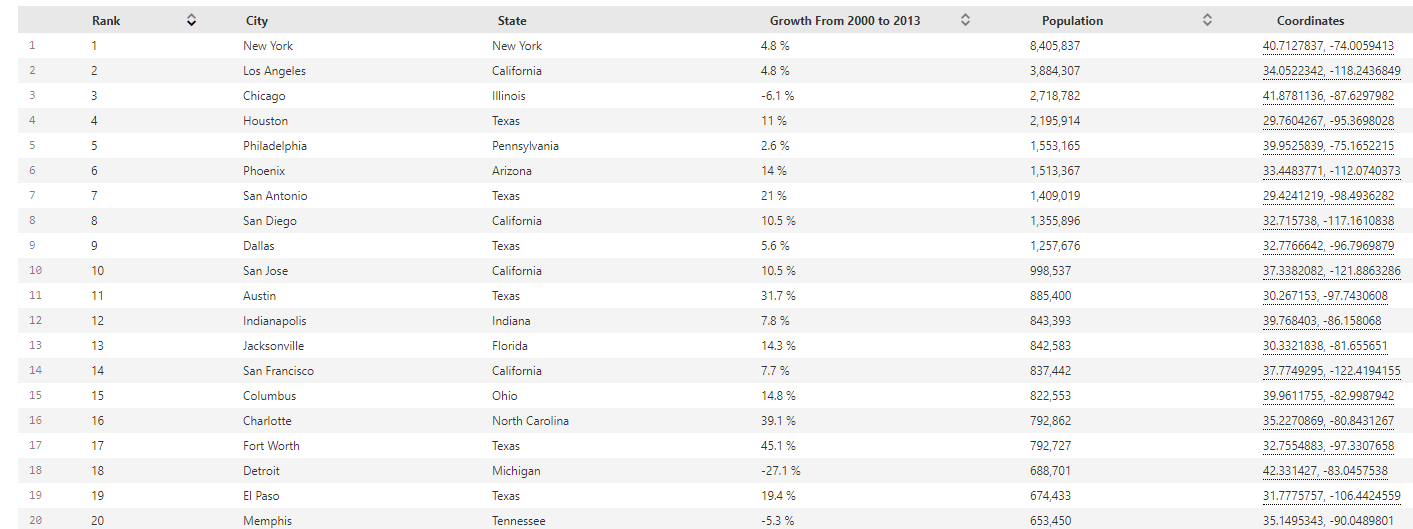

## Create the City list
You need to put all the cities as city objects in the cityList array. We will use the last column Coordinates to calculate the distance between all the cities. And for convenience we will multiply all the coordinates by 100. For example, for New York, it would be  
NewYork= City( int(40.71 * 100), int( -74.00 * 100))  
And then you can put cityList.append(NewYork)

Here is the sample code of calculating the path to travel top 5 cities of U.S.

In [155]:
cityList = []
NewYork= City( int(40.71 * 100), int( -74.00 * 100)) 
LA= City(3405,-11824) 
Chicago=City(4187,-8762)
Houston=City(2976,-9536)
Philly=City(3995,-7516)
cityList.append(NewYork)
cityList.append(LA)
cityList.append(Chicago)
cityList.append(Houston)
cityList.append(Philly)

Then, running the genetic algorithm is one simple line of code. This is where art meets science; you should see which assumptions work best for you. In this example, we have 100 individuals in each generation, keep 5 elite individuals, use a 1% mutation rate for a given gene, and run through 500 generations:

In [156]:
print(geneticAlgorithm(population=cityList, popSize=100, eliteSize=5, mutationRate=0.01, generations=500))

Initial distance: 9256.22933537916
Final distance: 9256.22933537916
[(-8762,4187), (-11824,3405), (-9536,2976), (-7516,3995), (-7400,4071)]


## Visualize the result path

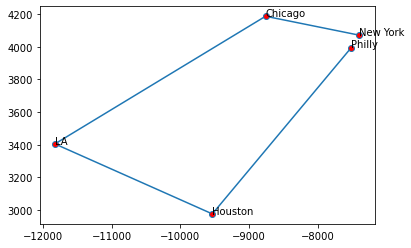

In [157]:
# Plotting
fig, ax1 = plt.subplots(ncols=1)
y=[4071,4187,3405,2976,3995]
x=[-7400,-8762,-11824,-9536,-7516]
n=['New York','Chicago',"LA","Houston","Philly"]
ax1.plot(x, y, marker="o", markerfacecolor="r")
for i, txt in enumerate(n):
    ax1.annotate(txt, (x[i], y[i]))

# Your Turn
Now write the code to calculate the ideal path for traveling the top 100 cities of U.S.

In [158]:
# Code to create larger cityList
# Implemented for you, to save some time.
cityList = []
NewYork=City(4069, -7392)
LosAngeles=City(3411, -11841)
Chicago=City(4184, -8769)
Miami=City(2578, -8021)
Dallas=City(3279, -9677)
Philadelphia=City(4001, -7513)
Houston=City(2979, -9539)
Atlanta=City(3376, -8442)
Washington=City(3890, -7702)
Boston=City(4232, -7108)
Phoenix=City(3357, -11209)
Seattle=City(4762, -12232)
SanFrancisco=City(3776, -12244)
Detroit=City(4238, -8310)
SanDiego=City(3283, -11712)
Minneapolis=City(4496, -9327)
Tampa=City(2799, -8245)
Denver=City(3976, -10488)
Brooklyn=City(4065, -7395)
Queens=City(4075, -7380)
Riverside=City(3394, -11739)
Baltimore=City(3931, -7661)
LasVegas=City(3623, -11527)
Portland=City(4554, -12265)
SanAntonio=City(2947, -9853)
StLouis=City(3864, -9025)
Sacramento=City(3857, -12147)
Orlando=City(2848, -8134)
SanJose=City(3730, -12185)
Cleveland=City(4148, -8168)
Pittsburgh=City(4044, -7998)
Austin=City(3030, -9775)
Cincinnati=City(3914, -8451)
KansasCity=City(3912, -9455)
Manhattan=City(4078, -7397)
Indianapolis=City(3978, -8615)
Columbus=City(3999, -8299)
Charlotte=City(3521, -8083)
VirginiaBeach=City(3673, -7604)
Bronx=City(4085, -7387)
Milwaukee=City(4306, -8797)
Providence=City(4182, -7142)
Jacksonville=City(3033, -8167)
SaltLakeCity=City(4078, -11193)
Nashville=City(3617, -8678)
Richmond=City(3753, -7748)
Memphis=City(3510, -8998)
Raleigh=City(3583, -7864)
NewOrleans=City(3007, -8993)
Louisville=City(3817, -8565)
OklahomaCity=City(3547, -9751)
Bridgeport=City(4119, -7320)
Buffalo=City(4290, -7885)
FortWorth=City(3278, -9735)
Hartford=City(4177, -7268)
Tucson=City(3215, -11088)
Omaha=City(4126, -9605)
ElPaso=City(3185, -10643)
Honolulu=City(2133, -15785)
McAllen=City(2623, -9825)
Albuquerque=City(3511, -10665)
Birmingham=City(3353, -8680)
Sarasota=City(2734, -8254)
Dayton=City(3978, -8420)
Rochester=City(4317, -7762)
Fresno=City(3678, -11979)
Allentown=City(4060, -7548)
Tulsa=City(3613, -9590)
CapeCoral=City(2664, -8200)
Concord=City(3797, -12200)
ColoradoSprings=City(3887, -10476)
Charleston=City(3282, -7996)
Springfield=City(4212, -7254)
GrandRapids=City(4296, -8566)
MissionViejo=City(3361, -11766)
Albany=City(4267, -7380)
Knoxville=City(3597, -8395)
Bakersfield=City(3535, -11904)
Ogden=City(4123, -11197)
BatonRouge=City(3044, -9113)
Akron=City(4108, -8152)
NewHaven=City(4131, -7292)
Columbia=City(3404, -8090)
Mesa=City(3340, -11172)
PalmBay=City(2796, -8066)
Provo=City(4025, -11165)
Worcester=City(4227, -7181)
Murrieta=City(3357, -11719)
Greenville=City(3484, -8236)
Wichita=City(3769, -9734)
Toledo=City(4166, -8358)
StatenIsland=City(4058, -7415)
DesMoines=City(4157, -9361)
LongBeach=City(3380, -11817)
PortStLucie=City(2728, -8039)
Denton=City(3322, -9714)
Madison=City(4308, -8939)
Reno=City(3955, -11985)
Harrisburg=City(4028, -7688)
LittleRock=City(3473, -9236)

cityList.append(NewYork)
cityList.append(LosAngeles)
cityList.append(Chicago)
cityList.append(Miami)
cityList.append(Dallas)
cityList.append(Philadelphia)
cityList.append(Houston)
cityList.append(Atlanta)
cityList.append(Washington)
cityList.append(Boston)
cityList.append(Phoenix)
cityList.append(Seattle)
cityList.append(SanFrancisco)
cityList.append(Detroit)
cityList.append(SanDiego)
cityList.append(Minneapolis)
cityList.append(Tampa)
cityList.append(Denver)
cityList.append(Brooklyn)
cityList.append(Queens)
cityList.append(Riverside)
cityList.append(Baltimore)
cityList.append(LasVegas)
cityList.append(Portland)
cityList.append(SanAntonio)
cityList.append(StLouis)
cityList.append(Sacramento)
cityList.append(Orlando)
cityList.append(SanJose)
cityList.append(Cleveland)
cityList.append(Pittsburgh)
cityList.append(Austin)
cityList.append(Cincinnati)
cityList.append(KansasCity)
cityList.append(Manhattan)
cityList.append(Indianapolis)
cityList.append(Columbus)
cityList.append(Charlotte)
cityList.append(VirginiaBeach)
cityList.append(Bronx)
cityList.append(Milwaukee)
cityList.append(Providence)
cityList.append(Jacksonville)
cityList.append(SaltLakeCity)
cityList.append(Nashville)
cityList.append(Richmond)
cityList.append(Memphis)
cityList.append(Raleigh)
cityList.append(NewOrleans)
cityList.append(Louisville)
cityList.append(OklahomaCity)
cityList.append(Bridgeport)
cityList.append(Buffalo)
cityList.append(FortWorth)
cityList.append(Hartford)
cityList.append(Tucson)
cityList.append(Omaha)
cityList.append(ElPaso)
cityList.append(Honolulu)
cityList.append(McAllen)
cityList.append(Albuquerque)
cityList.append(Birmingham)
cityList.append(Sarasota)
cityList.append(Dayton)
cityList.append(Rochester)
cityList.append(Fresno)
cityList.append(Allentown)
cityList.append(Tulsa)
cityList.append(CapeCoral)
cityList.append(Concord)
cityList.append(ColoradoSprings)
cityList.append(Charleston)
cityList.append(Springfield)
cityList.append(GrandRapids)
cityList.append(MissionViejo)
cityList.append(Albany)
cityList.append(Knoxville)
cityList.append(Bakersfield)
cityList.append(Ogden)
cityList.append(BatonRouge)
cityList.append(Akron)
cityList.append(NewHaven)
cityList.append(Columbia)
cityList.append(Mesa)
cityList.append(PalmBay)
cityList.append(Provo)
cityList.append(Worcester)
cityList.append(Murrieta)
cityList.append(Greenville)
cityList.append(Wichita)
cityList.append(Toledo)
cityList.append(StatenIsland)
cityList.append(DesMoines)
cityList.append(LongBeach)
cityList.append(PortStLucie)
cityList.append(Denton)
cityList.append(Madison)
cityList.append(Reno)
cityList.append(Harrisburg)
cityList.append(LittleRock)

In [187]:
# Code to run GA
GA_code = geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=100)
print(GA_code)


Initial distance: 189323.17557079834
Final distance: 120218.09913666247
[(-8420,3978), (-7748,3753), (-8680,3353), (-9113,3044), (-8066,2796), (-9825,2623), (-9853,2947), (-8939,4308), (-11527,3623), (-15785,2133), (-12232,4762), (-9455,3912), (-9734,3769), (-8615,3978), (-8566,4296), (-9751,3547), (-11209,3357), (-8167,3033), (-7864,3583), (-8152,4108), (-7254,4212), (-9025,3864), (-9539,2979), (-8299,3999), (-8998,3510), (-7661,3931), (-7380,4075), (-7702,3890), (-8254,2734), (-8310,4238), (-7292,4131), (-7762,4317), (-8168,4148), (-8083,3521), (-9327,4496), (-11712,3283), (-11817,3380), (-11172,3340), (-11193,4078), (-9361,4157), (-8769,4184), (-7996,3282), (-7142,4182), (-7268,4177), (-9714,3322), (-10665,3511), (-10476,3887), (-11165,4025), (-11985,3955), (-12265,4554), (-11739,3394), (-12200,3797), (-11979,3678), (-8678,3617), (-8993,3007), (-7392,4069), (-7548,4060), (-7380,4267), (-7998,4044), (-11197,4123), (-12185,3730), (-12244,3776), (-11841,3411), (-12147,3857), (-10643,31

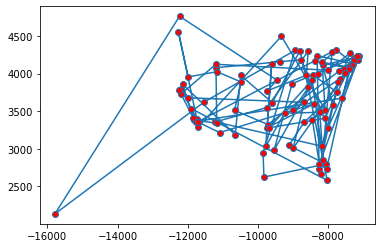

In [188]:
# Code to visulize the result path
# You don't need to label the cities.
# It's ok to hardcode the path directly (as in the example above), but it is possible to plot the results without hardcoding the coordinates.

fig, ax1 = plt.subplots(ncols=1)

y = []
x = []
for i in range(len(GA_code)):
    y.append(GA_code[i].y)
    x.append(GA_code[i].x)

ax1.plot(x, y, marker="o", markerfacecolor="r")
plt.show()


## Plot the progress

It’s great to know our starting and ending distance and the proposed route, but we would be remiss not to see how our distance improved over time. With a simple tweak to our geneticAlgorithm function, we can store the shortest distance from each generation in a progress list and then plot the results.

In [191]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    """
    This function should be very similar to the geneticAlgorithm function defined above, but it should also create a plot 
    the distance of the best route as a function of how many generations have passed. Please implement it below.
    """
    the_population = initialPopulation(popSize, population)
    s_dist = []
    s_dist.append(1/rankRoutes(the_population)[0][1])
    
    for i in range(0, generations):
        the_population = nextGeneration(the_population, eliteSize, mutationRate)
        s_dist.append(1/rankRoutes(the_population)[0][1])
    
    
    plt.plot(s_dist)
    plt.show()


Run the GA in the same way as before, but now using the newly created geneticAlgorithmPlot function:

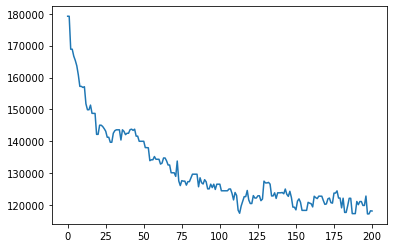

In [205]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=200)

## Conclusion
I hope this was a fun, hands-on assignment to learn how to build your own GA. Try it for yourself and see how short of a route you can get. Or go further and try to implement a GA on another problem set; see how you would change the breed and mutate functions to handle other types of chromosomes. We’re just scratching the surface here!